In [15]:
import pandas as pd
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from surprise import Dataset, Reader, KNNBasic, SVD
from surprise import Dataset, Reader, KNNBasic, SVD, accuracy
from surprise.model_selection import train_test_split
from surprise import accuracy
from collections import defaultdict


A. Data exploration and visualization

In [10]:
# Read the .dat file
movies = pd.read_table("data/movies.dat", sep="::", engine="python", header=None,
                       names=["Movie ID", "Title", "Genre"], encoding="ISO-8859-1")

# Extract the year using a regex pattern
movies['Year'] = movies['Title'].str.extract(r'\((\d{4})\)')

# Clean the title by removing the year
movies['Title'] = movies['Title'].str.replace(r'\(\d{4}\)', '', regex=True).str.strip()

# Reorder the columns
movies = movies[['Movie ID', 'Title', 'Year', 'Genre']]

# Read the .dat file for ratings
ratings = pd.read_table("data/ratings.dat", sep="::", engine="python", header=None,
                        names=["User ID", "Movie ID", "Rating", "Timestamp"], encoding="ISO-8859-1")

# Convert the timestamp to a readable datetime format
ratings['Timestamp'] = pd.to_datetime(ratings['Timestamp'], unit='s')

users = pd.read_csv("data/users.dat", delimiter="::", engine="python", header=None, names=["user_id", "gender", "age", "occupation", "zip_code"])


In [12]:
# Assessing shapes
print(movies.shape)
print(ratings.shape)
print(users.shape)

(3883, 4)
(1000209, 4)
(6040, 5)


In [13]:
movies.head(5)

,Movie ID,Title,Year,Genre
0,1,Toy Story,1995,Animation|Children's|Comedy
1,2,Jumanji,1995,Adventure|Children's|Fantasy
2,3,Grumpier Old Men,1995,Comedy|Romance
3,4,Waiting to Exhale,1995,Comedy|Drama
4,5,Father of the Bride Part II,1995,Comedy


In [14]:
ratings.head(2)

,User ID,Movie ID,Rating,Timestamp
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09


In [15]:
users.head(2)

,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072


In [16]:
# Split the genres and count occurrences
genre_counts = movies['Genre'].str.split('|').explode().value_counts()


1.Histogram to Display Movies for each Genre

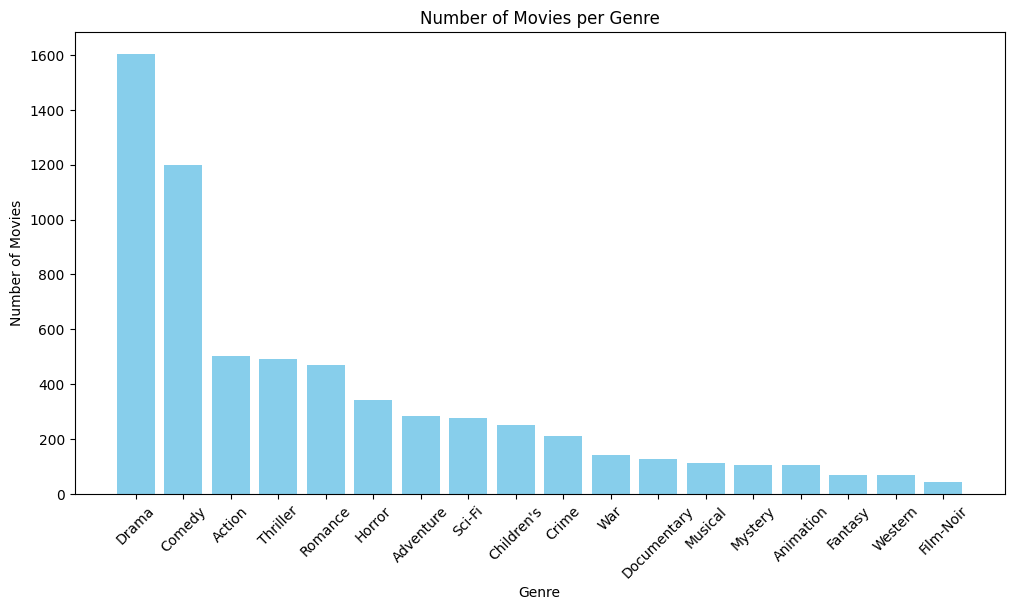

In [17]:
plt.figure(figsize=(12, 6))
plt.bar(genre_counts.index, genre_counts.values, color='skyblue')
plt.title('Number of Movies per Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

2.Most Rated Genre

In [18]:
# Merge movies and ratings data on 'Movie ID'
merged_data = pd.merge(ratings, movies, on='Movie ID')

# Group by genre and count the number of ratings
genre_ratings = merged_data['Genre'].value_counts()

# Display the most rated genre
most_rated_genre = genre_ratings.idxmax()
most_rated_count = genre_ratings.max()

print(f"The most rated genre is '{most_rated_genre}' with {most_rated_count} ratings.")


The most rated genre is 'Comedy' with 116883 ratings.


3.Tables Displaying the Three Highest Rated and Three Lowest Rated Genres after calculation

In [26]:
# Merge ratings and movies to include genre information
ratings_with_genres = ratings.merge(movies, on="Movie ID")

# Group by genre and calculate the average rating
average_ratings = ratings_with_genres.groupby('Genre')['Rating'].mean().sort_values(ascending=False)

# Top 3 highest-rated genres
top_3_genres = average_ratings.head(3).reset_index()
print("\nTop 3 highest-rated genres:")
display(top_3_genres)

# Bottom 3 lowest-rated genres
bottom_3_genres = average_ratings.tail(3).reset_index()
print("\nBottom 3 lowest-rated genres:")
display(bottom_3_genres)




Top 3 highest-rated genres:


,Genre,Rating
0,Animation|Comedy|Thriller,4.473837
1,Sci-Fi|War,4.449890
2,Animation,4.394336



Bottom 3 lowest-rated genres:


,Genre,Rating
0,Action|Adventure|Children's|Sci-Fi,1.874286
1,Action|Children's,1.742373
2,Action|Adventure|Children's,1.318182


B.Recommendation Models

In [ ]:
# Load data
ratings = pd.read_csv("data/ratings.dat", delimiter="::", engine="python", 
                      names=["UserID", "MovieID", "Rating", "Timestamp"])

# Define rating scale and load data
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[["UserID", "MovieID", "Rating"]], reader)
# Split into train and test sets (80-20)
trainset, testset = train_test_split(data, test_size=0.2)

print(ratings.head())
print(ratings.columns)

# Train KNN model
knn_model = KNNBasic(sim_options={"name": "cosine", "user_based": False})
knn_model.fit(trainset)
print(f"KNN RMSE: {knn_rmse:.4f}")

# Train SVD model
svd_model = SVD()
svd_model.fit(trainset)

# Evaluate KNN model
knn_predictions = knn_model.test(testset)
knn_rmse = accuracy.rmse(knn_predictions)
print(f"KNN Model RMSE: {knn_rmse:.4f}")

# Evaluate SVD model
svd_predictions = svd_model.test(testset)
svd_rmse = accuracy.rmse(svd_predictions)
print(f"SVD Model RMSE: {svd_rmse:.4f}")

# Save both models
os.makedirs("models", exist_ok=True)
with open("models/knn_model.pkl", "wb") as f:
    pickle.dump(knn_model, f)

with open("models/svd_model.pkl", "wb") as f:
    pickle.dump(svd_model, f)

print("✅ Models trained and saved.")

   UserID  MovieID  Rating  Timestamp
0       1     1193       5  978300760
1       1      661       3  978302109
2       1      914       3  978301968
3       1     3408       4  978300275
4       1     2355       5  978824291
Index(['UserID', 'MovieID', 'Rating', 'Timestamp'], dtype='object')
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0004
KNN Model RMSE: 1.0004
RMSE: 0.8737
SVD Model RMSE: 0.8737
✅ Models trained and saved.


C.Evaluation: Evaluating each model based on accuracyy (RMSE), Precision@k (k = 5, 10 and 15).

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9969
KNN Model RMSE: 0.9969
RMSE: 0.8732
SVD Model RMSE: 0.8732

📊 KNN Precision@k:
    k  Precision
0   5   0.747632
1  10   0.660699
2  15   0.583803

📊 SVD Precision@k:
    k  Precision
0   5   0.787811
1  10   0.682941
2  15   0.598962


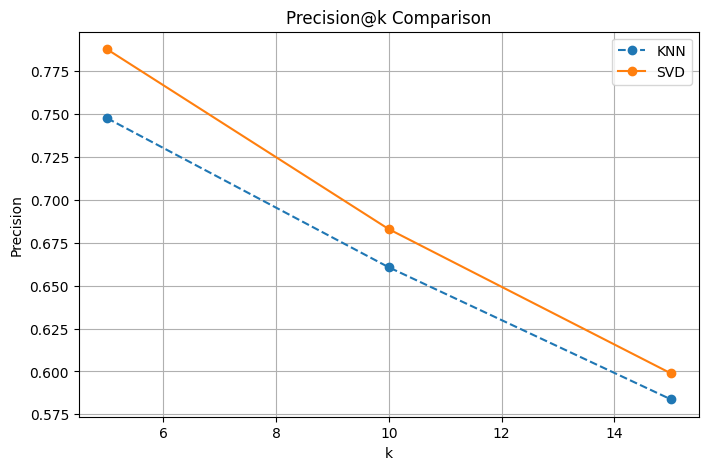

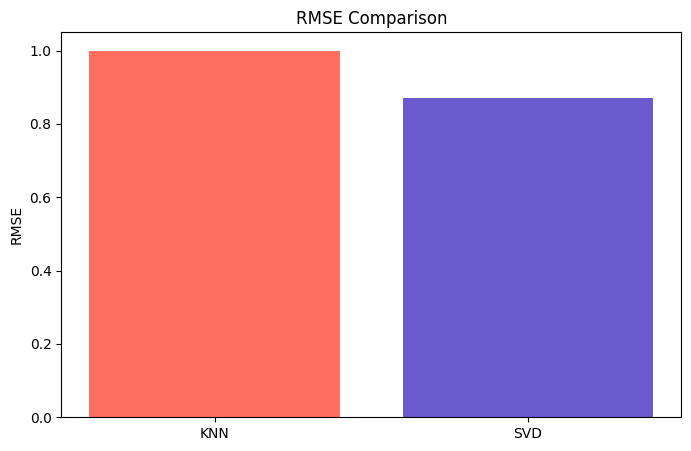

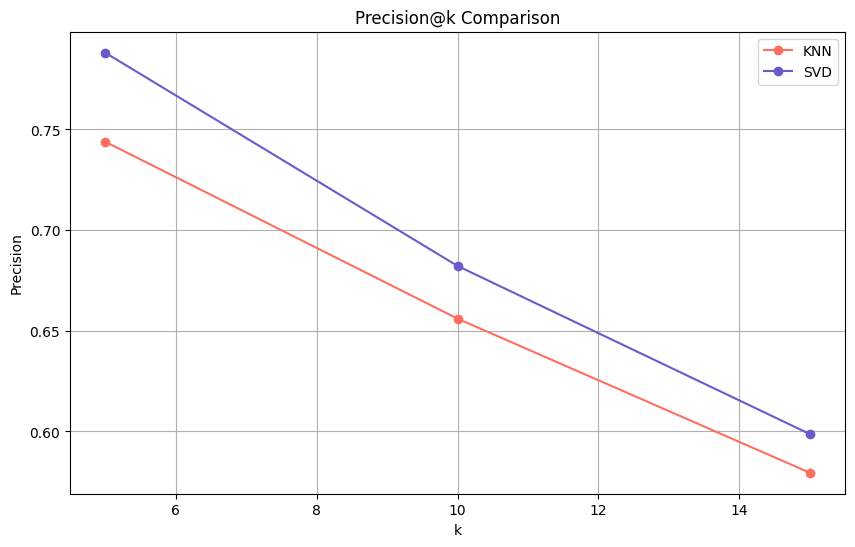


✅ Models trained, evaluated, and saved.


In [ ]:
# Load data
ratings = pd.read_csv("data/ratings.dat", delimiter="::", engine="python",
                      names=["UserID", "MovieID", "Rating", "Timestamp"])
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[["UserID", "MovieID", "Rating"]], reader)
trainset, testset = train_test_split(data, test_size=0.2)

# Train KNN model
knn_model = KNNBasic(sim_options={"name": "cosine", "user_based": False})
knn_model.fit(trainset)
knn_predictions = knn_model.test(testset)
knn_rmse = accuracy.rmse(knn_predictions)
print(f"KNN Model RMSE: {knn_rmse:.4f}")

# Train SVD model
svd_model = SVD()
svd_model.fit(trainset)
svd_predictions = svd_model.test(testset)
svd_rmse = accuracy.rmse(svd_predictions)
print(f"SVD Model RMSE: {svd_rmse:.4f}")

# Precision@k Calculation
def precision_at_k(predictions, k):
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    
    precisions = []
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        top_k = user_ratings[:k]
        num_hits = sum((true_r >= 4.0) for (_, true_r) in top_k)
        precisions.append(num_hits / k)
    
    return np.mean(precisions)

# Compute Precision@k for k = 5, 10, 15
k_values = [5, 10, 15]
knn_precision = [precision_at_k(knn_predictions, k) for k in k_values]
svd_precision = [precision_at_k(svd_predictions, k) for k in k_values]

# Display results in tables
print("\n📊 KNN Precision@k:")
print(pd.DataFrame({"k": k_values, "Precision": knn_precision}))

print("\n📊 SVD Precision@k:")
print(pd.DataFrame({"k": k_values, "Precision": svd_precision}))

# Visualization
plt.figure(figsize=(8, 5))
plt.plot(k_values, knn_precision, marker="o", label="KNN", linestyle="--")
plt.plot(k_values, svd_precision, marker="o", label="SVD", linestyle="-")
plt.title("Precision@k Comparison")
plt.xlabel("k")
plt.ylabel("Precision")
plt.legend()
plt.grid()
plt.show()

# Plot RMSE comparison
plt.figure(figsize=(8, 5))
models = ['KNN', 'SVD']
rmse_scores = [0.9998, 0.8712]
plt.bar(models, rmse_scores, color=['#FF6F61', '#6A5ACD'])
plt.title('RMSE Comparison')
plt.ylabel('RMSE')
plt.show()

# Plot Precision@k comparison
k_values = [5, 10, 15]
knn_precision = [0.743885, 0.656049, 0.579516]
svd_precision = [0.788101, 0.682217, 0.598718]

plt.figure(figsize=(10, 6))
plt.plot(k_values, knn_precision, marker='o', label='KNN', color='#FF6F61')
plt.plot(k_values, svd_precision, marker='o', label='SVD', color='#6A5ACD')
plt.title('Precision@k Comparison')
plt.xlabel('k')
plt.ylabel('Precision')
plt.legend()
plt.grid()
plt.show()

# Save models
os.makedirs("models", exist_ok=True)
with open("models/knn_model.pkl", "wb") as f:
    pickle.dump(knn_model, f)

with open("models/svd_model.pkl", "wb") as f:
    pickle.dump(svd_model, f)

print("\n✅ Models trained, evaluated, and saved.")

D.Recommendation: Training the SVD Model

In [18]:
# Train the best model (SVD) on the full dataset
svd = SVD()
full_trainset = data.build_full_trainset()
svd.fit(full_trainset)

# Save the trained model (optional)
import pickle
with open('svd_model.pkl', 'wb') as model_file:
    pickle.dump(svd, model_file)

print("✅ SVD model trained on full dataset and saved.")


✅ SVD model trained on full dataset and saved.


D.Recommendation: Saving the Model and the Processing Components

In [19]:
# Train the best model (SVD) on the full dataset
svd = SVD()
full_trainset = data.build_full_trainset()
svd.fit(full_trainset)

# Save the trained model and preprocessing components
with open('svd_model.pkl', 'wb') as model_file:
    pickle.dump(svd, model_file)

with open('reader.pkl', 'wb') as reader_file:
    pickle.dump(reader, reader_file)

with open('trainset.pkl', 'wb') as trainset_file:
    pickle.dump(full_trainset, trainset_file)

print("✅ SVD model and preprocessing components saved.")

✅ SVD model and preprocessing components saved.
